Kilka różnych modeli zostanie wytrenowanych na danych z katastrofy Titanic'a. Następnie dla atrybutu chronionego, którym została wybrana płeć, zostanie obliczonych kilka metryk fairness'u.

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [88]:
def computeFairnessMetrics(model, X, Y):
    
    tn, fp, fn, tp = confusion_matrix(model.predict(X), Y).ravel()
    
    statistical_parity_ratio = (tp + fp) / (tp + fp + tn + tp)
    equal_opportunity_ratio = tp / (tp + fn)
    predictive_equality_ratio = fp / (fp + tn)
    predictive_parity_ratio = tp / (tp + fp)

    fairnessDict = {"statistical_parity_ratio" : statistical_parity_ratio, 
                    "equal_opportunity_ratio" : equal_opportunity_ratio,
                    "predictive_equality_ratio" : predictive_equality_ratio,
                    "predictive_parity_ratio" : predictive_parity_ratio}
    
    return fairnessDict

In [119]:
data = pd.read_csv("train.csv")
# get rid of passenger id, name and age
cleaned = data.drop(['PassengerId', 'Name', 'Age'], axis=1)
dummies = pd.get_dummies(cleaned)

X = dummies.drop('Survived', axis=1)
Y = dummies.Survived
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=6)

In [120]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [121]:
print(f"Training accuracy: {gbc.score(X_train, y_train)}. Validation accuracy: {gbc.score(X_test, y_test)}")

Training accuracy: 0.8459069020866774. Validation accuracy: 0.832089552238806


In [122]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [123]:
print(f"Training accuracy: {rf.score(X_train, y_train)}. Validation accuracy: {rf.score(X_test, y_test)}")

Training accuracy: 0.9967897271268058. Validation accuracy: 0.8395522388059702


In [124]:
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [125]:
print(f"Training accuracy: {knn.score(X_train, y_train)}. Validation accuracy: {knn.score(X_test, y_test)}")

Training accuracy: 0.841091492776886. Validation accuracy: 0.75


In [126]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [127]:
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [128]:
print(f"Training accuracy: {svm.score(X_train, y_train)}. Validation accuracy: {svm.score(X_test, y_test)}")

Training accuracy: 0.6789727126805778. Validation accuracy: 0.6753731343283582


In [129]:
models = [gbc, rf, knn, lr]
names = ["gradient boosting", "random forest", "KNN", "logistic regression"]

In [130]:
results = []
X_val_male = X_test[X_test['Sex_male'] == 1]
y_val_male = y_test[X_test['Sex_male'] == 1]
X_val_female = X_test[X_test['Sex_female'] == 1]
y_val_female = y_test[X_test['Sex_female'] == 1]

for i in range(len(models)):
    fairnessDictMale = computeFairnessMetrics(models[i], X_val_male, y_val_male)
    for k, v in fairnessDictMale.items():
        results.append(pd.DataFrame({'metric' : k, 'score' : v, 'sex' : 'male', 'model' : names[i]}, index=[0]))
    
    fairnessDictFemale = computeFairnessMetrics(models[i], X_val_female, y_val_female)
    for k, v in fairnessDictFemale.items():
        results.append(pd.DataFrame({'metric' : k, 'score' : v, 'sex' : 'female', 'model' : names[i]}, index=[0]))

In [131]:
combo = pd.concat(results)

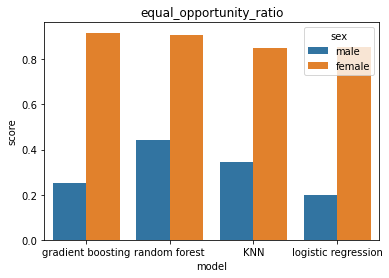

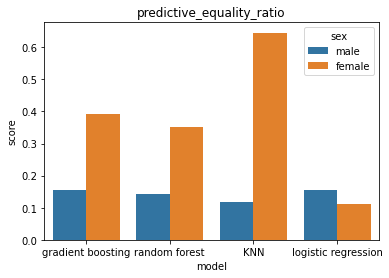

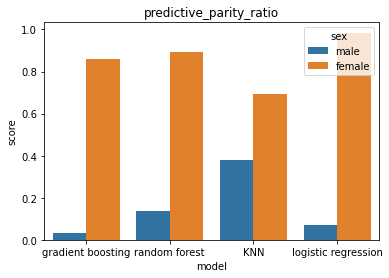

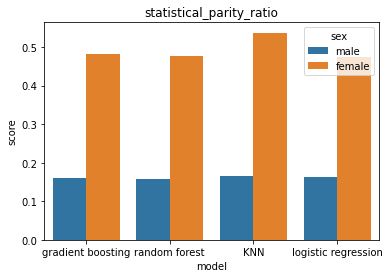

In [132]:
for metric, df in combo.groupby('metric'):
    male = df[df.sex == 'male']
    female = df[df.sex == 'female']
    
    sns.barplot(data=df[df["metric"].eq(metric)], x="model", y="score", hue="sex")
    plt.title(metric)
    plt.show()

Wnioski: <br>
- metryki fairnessu są bardzo zróżnicowane dla wytrenowanych modeli
- tylko dla regresji logistycznej występuje jedna metryka, która ma większą wartość dla mężczyzn. Jest to "predictive equality". Oznacza to, że model częściej się myli w przypadku mężczyzn, którzy nie przeżyli katastrofy, niż w przypadku kobiet, które nie przeżyły katastrofy
- jest ogromna różnica pomiędzy wartościami "predictive parity" w przypadku modelu gradient boosting. W tym przypadku odsetek mężczyzn, którzy przeżyli katastrofę, spośród mężczyzn, którzy według modelu przeżyli katastrofę, jest bardzo mały. Inna sytuacja występuje dla kobiet. Jeżeli model uzna, że kobieta przeżyje katastrofę, to z dużym prawdopodobieństwem (~85%) model się nie myli. Nie można tego powiedzieć w przypadku mężczyzn
- trudno jest wyróżnić najlepszy model. Wybór najlepszego modelu zależy od tego, na jakiej metryce nam najbardziej zależy 
- na pewno płeć miała ogromną kontrybucję do predykcji modeli. Jest to sytuacja niepożądana z perspektywy fairnessu modelu 